# Stochastic Multi-Armed Bandit and Bootstrapping

[Imad AOUALI](https://www.linkedin.com/in/imad-aouali/)

Multi-Armed bandits have attracted a lot of attention in various applications, from recommender systems and information retrieval to healthcare and finance, due to their performance, their simplicity and properties such as learning from partial feed back. Bootstrapping is a powerful, computer-based method for statistical inference. It is a resampling method which samples independently with replacement from an existing sample data with same sample size $n$, and performing inference among these resampled data. Two recent papers proposed Bootstrap-based approaches for multi-armed bandit problems. This notebook aims to provide a comprehensive review of the use of Bootstrapping in multi-armed bandit problems by contrasting those approaches and discussing their benefits compared to other bandit approaches like UCB, kl-UCB, and Thompson Sampling.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.stats.mstats import mquantiles

# Bandit specific functions and classes 
import Arms as arm
from StochasticBandit import *
from BanditTools import * 
import BanditBaselines as alg

# I) Problem setup

Different arm classes are defined in `Arms.py`. A multi-armed bandit is simply a list of such arms.

In [2]:
def OneBanditOneLearnerOneRun(bandit, learner, timeHorizon):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps
    output : sequence of arms chosen, sequence of rewards obtained
    """
    selections = []
    rewards = []
    learner.clear() # reset previous history
    for t in range(timeHorizon):
        arm = learner.chooseArmToPlay()
        reward = bandit.generateReward(arm)
        learner.receiveReward(arm, reward)
        # Update statistics
        selections.append(arm)
        rewards.append(reward)
    return selections, rewards
    
def CumulativeRegret(bandit,selections):
    """Compute the pseudo-regret associated to a sequence of arm selections"""
    return np.cumsum(max(bandit.means)*np.ones(len(selections)) - np.array(bandit.means)[selections])

def OneBanditOneLearnerMultipleRuns(bandit, learner, timeHorizon, N_exp, tsave=[]):
    """
    Run a bandit strategy (learner) on a MAB instance (bandit) for (timeHorizon) time steps, (N_exp) times
    output : (N_exp) sequences of rewards obtained for each experiment represented as a matrix.
    """
    if (len(tsave) == 0):
        tsave = np.arange(timeHorizon)
    savedTimes = len(tsave)
    Regret = np.zeros((N_exp, savedTimes)) # Store the regret values on different runs
    for n in range(N_exp):
        np.random.seed()
        selections, rewards = OneBanditOneLearnerOneRun(bandit, learner, timeHorizon)
        regret_one_run = CumulativeRegret(bandit, selections)
        Regret[n, :] = np.array(regret_one_run)[tsave] # Store a sub-sampling of the cumulative regret
    return Regret

# II) Classical MAB Algorithms

## 1) The vanilla UCB algorithm

The vanilla UCB algorithm is proposed by [Auer et al](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) for bandit instances with bounded rewards (in $[0,1]$ to fix the ideas). One can extend it to depend on some parameter $\alpha$: 

$$A_{t} = \underset{a}{\text{argmax}} \left[\hat{\mu}_a(t-1) + \sqrt{\frac{\alpha \log(t)}{N_a(t-1)}}\right],$$
where $\hat{\mu}_a(t)$ is the empirical mean of arm $a$ after $t$ rounds and $N_a(t)$ is the number of selections of arm $a$ till that time. 

UCB1 was originally proposed with $\alpha = 2$. Its analysis was later refined to allow for $\alpha > 1/2$ (see [here](http://sbubeck.com/Bubeckthesis.pdf) or [here](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf)).

In [3]:
class UCB:
    """vanilla UCB with parameter alpha"""
    def __init__(self, nbArms, alpha=1/2):
        self.nbArms = nbArms
        self.alpha = alpha
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = self.cumRewards/self.nbDraws + np.sqrt(self.alpha*log(self.t)/self.nbDraws)
            return randmax(index) 

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "UCB"

## 2) kl-UCB

In the Bernoulli case, we now investigate an algorithm designed for matching the Lai and Robbins lower bound, that is $\mathrm{kl}$-UCB, proposed by [Cappé et al](https://hal.archives-ouvertes.fr/hal-00738209/file/klucb.pdf). It is also a UCB algorithm, but the upper confidence bound is more sophisticated: 

$$\mathrm{UCB}_a(t) = \max \left\{ q : N_a(t) \mathrm{kl}\left(\hat{\mu}_a(t),q\right) \leq \log(t) + c\log\log(t) \right\},$$
where $\mathrm{kl}(\mu,\mu')$ is the KL-divergence between the distribution with mean $\mu$ and that of mean $\mu'$ in some exponential family and $c$ is some real parameter (often chosen to be zero in practice).

In the Bernoulli case, this is the Bernoulli KL-divergence $\mathrm{kl}(x,y) = x\log(x/y) + (1-x)\log((1-x)/(1-y)).$

In [4]:
class klUCB:
    """klUCB (Bernoulli divergence by default)"""
    def __init__(self, nbArms, divergence=klucbBern, c=0):
        self.nbArms = nbArms
        self.divergence = divergence
        self.c = c
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = np.zeros(self.nbArms)
            for a in range(self.nbArms):
                index[a] = self.divergence(self.cumRewards[a]/self.nbDraws[a], (log(self.t)+self.c*log(log(self.t)))/self.nbDraws[a])
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward

    def name(self):
        return "kl-UCB"

## 3) A Bayesian strategy: Thompson Sampling 

The algorithm is implemented as follows: 

$$\forall a, \theta_a(t) \sim \pi_a(t-1), \ \ \ A_{t} = \underset{a}{\text{argmax }} \theta_a(t)$$

In the Bernoulli case, with a uniform (or more generally a Beta$(\alpha,\beta)$) prior distribution on each mean, the posterior distribution remains a Beta distribution. More precisely, one has

$$\pi_a(t) = \mathrm{Beta}\left(\alpha + S_a(t), \beta + N_a(t) - S_a(t)\right),$$

where $S_a(t)$ is the sum of rewards received from arm $a$ after $t$ rounds, and $N_a(t)$ is the number of selections of that arm, as before.

In [5]:
class ThompsonSampling:
    """Thompson Sampling with Beta(a,b) prior and Bernoulli likelihood"""
    def __init__(self, nbArms, a=1, b=1):
        self.nbArms = nbArms
        self.a = a
        self.b = b
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
    
    def chooseArmToPlay(self):
        posterior_samples = np.zeros(self.nbArms)
        for a in range(self.nbArms):
            posterior_samples[a]= np.random.beta(self.cumRewards[a]+self.a, self.nbDraws[a]-self.cumRewards[a]+self.b)
        return randmax(posterior_samples)

    def receiveReward(self, arm, reward):
        rewbinary = binreward = float(np.random.random()<reward)
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + rewbinary

    def name(self):
        return "Thompson Sampling"

# III) Bootstrap-Based Algorithms

## 1) Bootstrapped UCB

The Bootstrapped UCB algorithm is proposed by [Botao et al.](https://arxiv.org/abs/1906.05247) for bandit instances with bounded rewards in $(0,1)$.

$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n_{k, t}}-\bar{y}_{n_{k, t}}\right)+\sqrt{\frac{\log (2 / \alpha \delta)}{n_{k, t}}} \varphi\left(\boldsymbol{y}_{n_{k, t}}\right)
$$

where $q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n}-\bar{y}_{n}\right)$ is (1 - $\alpha(1-\delta)$)-quantile of the distribution of $\bar{y}_{n}-\mu$ and $\varphi\left(\boldsymbol{y}_{n}\right)$ is a non-negative function satisfying $\mathbb{P}_{\boldsymbol{y}}\left(\left|\bar{y}_{n}-\mu\right| \geq \varphi\left(\boldsymbol{y}_{n}\right)\right) \leq \alpha$.


#### a) Bootstrapped UCB : The Theoretical Configurations

We observed that the configuration used by the authours of the paper in experiments was different from the theoretical configuration. In this section we are going to use two possible configurations that guarantee certain properties. The configuration is as follows :
$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n_{k, t}}-\bar{y}_{n_{k, t}}\right)+\sqrt{\frac{\log (2 / \alpha \delta)}{n_{k, t}}} \varphi\left(\boldsymbol{y}_{n_{k, t}}\right)
$$
where $ \varphi\left(\boldsymbol{y}_{n}\right) = (2 \log (1 / \alpha) / n)^{1 / 2}$. This leads to the first theoretical version
$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n_{k, t}}-\bar{y}_{n_{k, t}}, w^B\right)+\sqrt{\frac{2 \log (2 / \alpha \delta) \log (1 / \alpha)}{n_{k, t}^2}}
$$

We have another function that gave us theoretical guaranties regarding the regret (both problem-depent and problem-independent) is as follows :

$$
\varphi\left(\boldsymbol{y}_{n_{k, t}}\right)=C_{\beta} \sigma\left(\sqrt{\frac{\log 1 / \alpha}{n_{k, t}}}+\frac{(\log 2 / \alpha)^{1 / \beta}}{n_{k, t}}\right)
$$

If we consider our rewards to be  1-sub-Gaussian random variables then $\beta = 2$ and $\sigma = 1$, we set $C_{\beta} = 1$. Then the function becomes :


$$
\varphi\left(\boldsymbol{y}_{n_{k, t}}\right)= \left(\sqrt{\frac{\log 1 / \alpha}{n_{k, t}}}+\frac{\sqrt{(\log 2 / \alpha)}}{n_{k, t}}\right)
$$


So by plugging that function into the main equation, the second version is :

$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n_{k, t}}-\bar{y}_{n_{k, t}}, w^B\right)+\sqrt{\frac{\log (2 / \alpha \delta)}{n_{k, t}}} \left(\sqrt{\frac{\log 1 / \alpha}{n_{k, t}}}+\frac{\sqrt{(\log 2 / \alpha)}}{n_{k, t}}\right)
$$



In [23]:
class TheoBootstrapUCB:
    """BootstrapUCB with parameter delta and B
    - delta : Hyperparameter
    - B : Number of bootstrap samples
    - vers : 0 for the first theoretical version and 1 for second
    """
    def __init__(self, nbArms, delta = 0.1, B = 200, vers = 0):
        self.nbArms = nbArms
        self.delta = delta
        self.B = B
        self.vers = vers
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
        self.rewar = [[] for i in range(self.nbArms)]
        
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            alpha = 1/2000
            quantiles = np.zeros(self.nbArms)
            for arm in range(self.nbArms):
                s = np.random.choice([-1,1], size = (self.B,int(self.nbDraws[arm])))
                values = (1/self.nbDraws[arm])*np.sum(s*(np.array(self.rewar[arm]) - np.array(self.rewar[arm]).mean()), axis = 1)
                quant = mquantiles(values, 1 - (alpha * (1 - self.delta)))[0]
                quantiles[arm] = quant
            if self.vers == 0:
                index = self.cumRewards/self.nbDraws + quantiles + (((2*np.log(2/(alpha*self.delta)))*(2*np.log(1/alpha)))**0.5)/self.nbDraws 
            elif self.vers == 1:
                second_order = ((np.log(1/alpha))/self.nbDraws)**0.5 + ((np.log(2/alpha))**0.5)/self.nbDraws
                index = self.cumRewards/self.nbDraws + quantiles + ((np.log(2/(alpha*self.delta))/self.nbDraws)**0.5)*second_order
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        self.rewar[arm].append(reward)

    def name(self):
        if self.vers == 0:
            return "Theoretical BootstrapUCB, First Version"
        else:
            return "Theoretical BootstrapUCB, Second Version"

#### b) Bootstrapped UCB : The Experimental Configuration

The paper suggests the following configuration that is different from the theoretical ones : 
- We set the second-order correction term to $ n_{k,t}^{-1} \sqrt{2log(\frac{1}{\alpha})}$.
- at each t, we set $\alpha = \frac{1}{tlog(t)}$, Note that in the paper they show that $\alpha = \frac{1}{T^2}$ gaves theoretical guaranties. However, they mentionned that we can have the same guaranties with $\alpha = \frac{1}{tlog(t)^p} \forall p > 0$, we choose $p=1$ in this case.

Using this configuration, Bootstrapped UCB strategy is as follows : 
$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+q_{\alpha(1-\delta)}\left(\boldsymbol{y}_{n_{k, t}}-\bar{y}_{n_{k, t}}, w^B\right)+ \frac{\sqrt{2log(\frac{1}{\alpha})}}{n_{k,t}}
$$
- Note that we don't loop to generate the B bootstrap samples. Insteed, we create directly a matrix with size (B, NbDraws) where each line represents a bootstrap sample. We did this to reduce the computational complexity.

In [7]:
class BootstrapUCB:
    """BootstrapUCB with parameter delta and weights
    - delta : Hyperparameter
    - weights : integer , 0 for multinomial weights and 1 for rademacher weights.
    - B : Number of bootstrap samples
    """
    def __init__(self, nbArms, delta = 0.1, B = 200, weights = 1):
        self.nbArms = nbArms
        self.delta = delta
        self.weights = weights
        self.B = B
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
        self.rewar = [[] for i in range(self.nbArms)]
        
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            alpha_0 = 1/(self.t*np.log(self.t))
            quantiles = np.zeros(self.nbArms)
            for arm in range(self.nbArms):
                if self.weights == 1 :
                    s = np.random.choice([-1,1], size = (self.B,int(self.nbDraws[arm])))
                else :
                    s = np.random.multinomial(self.nbDraws[arm], [1/(self.nbDraws[arm])]*int((self.nbDraws[arm])), size=self.B)
                values = (1/self.nbDraws[arm])*np.sum(s*(np.array(self.rewar[arm]) - np.array(self.rewar[arm]).mean()), axis = 1)
                quant = mquantiles(values, 1 - (alpha_0 * (1 - self.delta)))[0]
                quantiles[arm] = quant
            index = self.cumRewards/self.nbDraws + quantiles + ((2 * np.log(1/alpha_0)) ** 0.5)/self.nbDraws 
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        self.rewar[arm].append(reward)

    def name(self):
        if self.weights == 0:
            return "BootstrapUCB, multinomial weights"
        else :
            return "BootstrapUCB, rademacher weights"

## 2) Giro :

Giro is a bandit algorithm that explores by randomizing its history of rewards. Specifically, it pulls the arm with the highest mean reward in a non-parametric bootstrap sample of its history __with pseudo rewards__. 
The strategy of adding pseudo rewards is marked in the code bellow.

In [8]:
class Giro:
    """Giro
    """
    def __init__(self, nbArms, a = 0.1):
        self.nbArms = nbArms
        self.a = a
        self.clear()
        
    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
        self.rewar = [[] for i in range(self.nbArms)]
        
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            index = []
            for arm in range(self.nbArms):    
                
                #Pseudo Rewards strategy
                pseudo_pulls = self.a * self.nbDraws[arm]
                floor_pulls = np.floor(pseudo_pulls).astype(int)
                if pseudo_pulls == floor_pulls: #To avoid the case where probabilities do not sum to 1
                    pulls = floor_pulls
                else : 
                    ceil_pulls = np.ceil(pseudo_pulls).astype(int)
                    pulls = np.random.choice([floor_pulls, ceil_pulls], 1, p=[pseudo_pulls - floor_pulls, ceil_pulls - pseudo_pulls])[0]
                
                history = np.concatenate((self.rewar[arm], np.zeros(pulls), np.ones(pulls)))
                bootstrap = np.random.randint(0, history.size, history.size)         
                index.append(history[bootstrap].mean())
                
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        self.rewar[arm].append(reward)
    def name(self):
        return "Giro"

# IV) My UCB Version

- Here, we propose what we called the UCB0. We'll show that this method provides very good performances.

- This UCB version raised when were investigating the importance of the quantile term, becaused we wanted to get rid of it due to tha fact that the estimation of the quantile adds extra complexity to the algorithm without being non-asymptotically valid (no theoretical guaranties) : We needed to add second-order correction, so we thought that the second-order term is the main reason of the good performances of this algorithm.
- Based on this, our version of UCB chooses an arm as follow : 
$$
\mathrm{UCB}_{k}(t)=\bar{y}_{n_{k, t}}+ \frac{\sqrt{2log(\frac{1}{\alpha})}}{n_{k,t}}
$$

__Confidence Interval__ For 1-sub-Gaussian rewards, one can prove using Hoeffding’s inequality that : $\mathbb{P}_{y}\left(\left|\bar{y}_{n}-\mu\right| \le \frac{\sqrt{2 \log \left(\frac{1}{\alpha_t}\right)}}{n})\right) \ge 1 - \frac{2\alpha_t^4}{n^4}$

In [9]:
class UCB0:
    """UCB0
    """
    def __init__(self, nbArms):
        self.nbArms = nbArms
        self.clear()

    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
        self.rewar = [[] for i in range(self.nbArms)]
        
    def chooseArmToPlay(self):
        if (min(self.nbDraws)==0):
            return randmax(-self.nbDraws)
        else:
            alpha_0 = 1/(self.t*np.log(self.t))
            quantiles = np.zeros(self.nbArms)
            index = self.cumRewards/self.nbDraws + ((2 * np.log(1/alpha_0)) ** 0.5)/self.nbDraws 
            return randmax(index)

    def receiveReward(self, arm, reward):
        self.t = self.t + 1
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        self.cumRewards[arm] = self.cumRewards[arm] + reward
        self.rewar[arm].append(reward)
    def name(self):
        return "UCB0"

# V) Experiments :

## 1) Comparing Bootstrapped UCB and Giro with classical approaches

### a) Bernoulli Bandit

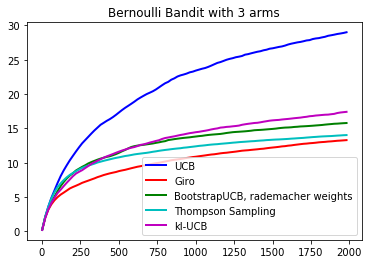

In [10]:
means = [0.1, 0.05, 0.25]
bandit = BernoulliBandit(means)
K = len(means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [UCB(K), Giro(K), BootstrapUCB(K), ThompsonSampling(K), klUCB(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())
plt.title('Bernoulli Bandit with ' + str(K) + " arms")
plt.legend()

### b) TruncatedExponential Bandit

arm means are
[0.36716600055044046, 0.3167376438773787, 0.27708646187933755]


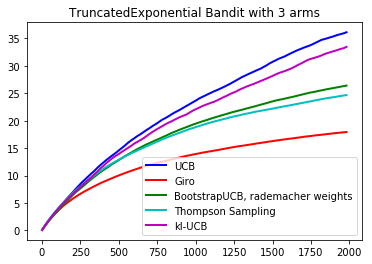

In [11]:
bandit = MAB([arm.TruncatedExponential(2.5, 1), arm.TruncatedExponential(3, 1), arm.TruncatedExponential(3.5, 1)])
print("arm means are")
print(bandit.means)
K = len(bandit.means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [UCB(K), Giro(K), BootstrapUCB(K), ThompsonSampling(K), klUCB(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())

plt.title('TruncatedExponential Bandit with ' + str(K) + " arms")
plt.legend()

$\rightarrow$ Overall, Giro and Bootstrapped UCB outperforms other approaches, or have comparable performance with Thompson Sampling when the prior is well chosen. With a well chosen configuration, Giro outperforms or sometimes has comparable performance with Bootstrapped UCB.

## 2) Studying the influence of hyperparameters

### a) Parameter $\delta$ for the Bootstrapped UCB Algorithm

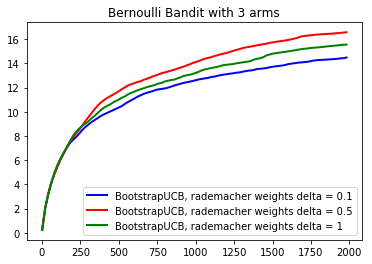

In [12]:
means = [0.1, 0.05, 0.25]
bandit = BernoulliBandit(means)
K = len(means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)
deltas = [0.1 , 0.5, 1]
algos = [BootstrapUCB(K, delta = deltas[i]) for i in range(len(deltas))]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name() + " delta = " + str(deltas[i]))
plt.title('Bernoulli Bandit with ' + str(K) + " arms")
plt.legend()

### b) Parameter $a$ for Giro Algorithm on Bernoulli Bandit

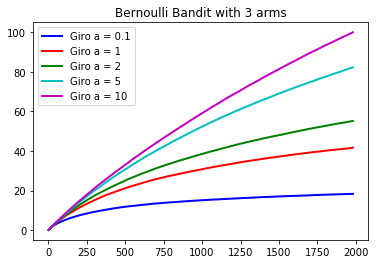

In [13]:
means = [0.1, 0.05, 0.2]
bandit = BernoulliBandit(means)
K = len(means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)
a = [0.1, 1, 2, 5, 10]
algos = [Giro(K, a[i]) for i in range(len(a))]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name() + " a = " + str(a[i]))
plt.title('Bernoulli Bandit with ' + str(K) + " arms")
plt.legend()

### c) Parameter $a$ for Giro Algorithm on Truncated Exponential Bandit

arm means are
[0.36716600055044046, 0.3167376438773787, 0.27708646187933755]


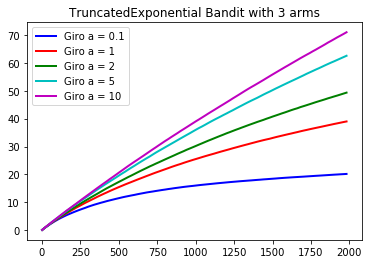

In [14]:
bandit = MAB([arm.TruncatedExponential(2.5, 1), arm.TruncatedExponential(3, 1), arm.TruncatedExponential(3.5, 1)])
print("arm means are")
print(bandit.means)
K = len(bandit.means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)
a = [0.1, 1, 2, 5, 10]
algos = [Giro(K, a[i]) for i in range(len(a))]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name() + " a = " + str(a[i]))
plt.title('TruncatedExponential Bandit with ' + str(K) + " arms")
plt.legend()

$\rightarrow$ The strategy of adding pseudo rewards is a real challenge. The choice of the value of the hyperparameter $a$ is mandatory for Giro algorithm, a bad choice of a easily leads to linear regret. Unlike Giro, the parameter $\delta$ doesn’t have an impact on the regret of Bootstrapped UCB.

$\rightarrow$ The fact that $\delta$ doesn’t have an influence on the regret strengthens our hypothesis about the importance of the quantile term in the Bootstrapped UCB, since the quantile is the only term where $\delta$ appears.

## 3) Comparing our Version of UCB with BootstrapUCB and Giro

### a) Bernoulli Bandit

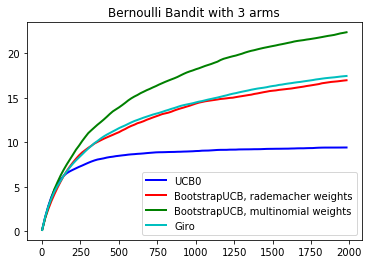

In [15]:
means = [0.1, 0.05, 0.2]
bandit = BernoulliBandit(means)
K = len(means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [UCB0(K),BootstrapUCB(K), BootstrapUCB(K,weights = 0), Giro(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())
plt.title('Bernoulli Bandit with ' + str(K) + " arms")
plt.legend()

### b) Truncated Exponential Bandit

arm means are
[0.36716600055044046, 0.3167376438773787, 0.27708646187933755]


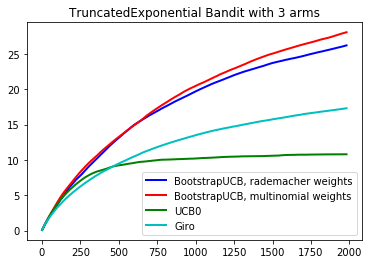

In [16]:
bandit = MAB([arm.TruncatedExponential(2.5, 1), arm.TruncatedExponential(3, 1), arm.TruncatedExponential(3.5, 1)])
print("arm means are")
print(bandit.means)
K = len(bandit.means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [BootstrapUCB(K), BootstrapUCB(K,weights = 0), UCB0(K), Giro(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())
plt.title('TruncatedExponential Bandit with ' + str(K) + " arms")
plt.legend()

$\rightarrow$ The choice of the weights distribution for the multiplier bootstrap can be mandatory in some Bandit problems (e.g. Bernoulli Bandit). In other cases, it doesn't have a big influence on the perforamance  (e.g. TruncatedExponential Bandit ). Overall, the Rademacher distribution seems like the best choice since it provides good results in pratice and give us theoretical guaranties.

$\rightarrow$  UCB0 outperforms Giro and bootstrapped UCB in both cases, we observe that its cummulative regret curve is always under the curve of the other algorithms (Except somecases where Giro does better for early times (e.g. TruncatedExponential Bandit for the first 300 selections). Also, for $t$ large enough, UCB0 take always the best decision, this is can be explained by its horizontal curve after some $t_0$, which means that for $t \ge t_0$, the regret doesn't change and stays equal to $R(t_0)$. In addition, unlike the other approaches that take time to come to a result (indeed they are expensive, and some times unethical), UCB0 seems to learn very quickly. 

## 4) Comparing Theoretical and Experimental Bootstrapped UCB

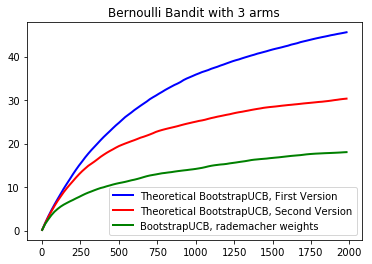

In [24]:
means = [0.1, 0.05, 0.2]
bandit = BernoulliBandit(means)
K = len(means)

nExp = 100
timeHorizon = 2000
tsave = np.arange(1, timeHorizon, 20)

algos = [TheoBootstrapUCB(K, vers = 0), TheoBootstrapUCB(K, vers = 1), BootstrapUCB(K)]
colors = ["b", "r", "g", "c", "m"]

for i in range(len(algos)):
    algo = algos[i]
    Regret = OneBanditOneLearnerMultipleRuns(bandit, algo, timeHorizon, nExp, tsave)
    plt.plot(tsave, np.mean(Regret, 0), linewidth=2.0, color=colors[i], label=algo.name())
plt.title('Bernoulli Bandit with ' + str(K) + " arms")
plt.legend()

$\rightarrow$ Overall, the regret isn't linear for every configurations, which is good. However, this result is very surprising since the main configuration of Bootstrapped UCB outperforms theoretical configurations. Therefore, the trick of setting the second-order correction term to $n_{k, t}^{-1}\left(2 \log \left(\frac{1}{\alpha}\right)\right)^{1 / 2}$ was mandatory and clever, it improved the performance of Bootstrapped UCB.
